# Compute changepoints for a dataset before and after transformation

In [1]:
import re
import h5py
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from toolz.curried import get, pluck, get_in
from toolz import groupby, valmap, compose, curry, partial
from aging.size_norm.data import clean
from aging.behavior.scalars import compute_scalars, im_moment_features
from sklearn.random_projection import GaussianRandomProjection
from scipy.ndimage import gaussian_filter, shift, rotate
from aging.plotting import (
    format_plots,
    PlotConfig,
    save_factory,
    figure,
    legend,
    IMG_KWARGS,
    ONTOGENY_AGE_CMAP
)

In [2]:
data = joblib.load('/n/scratch/users/w/wg41/aging-aligned-frames_version12.p')

In [3]:
group_recon = groupby(get_in([0, -1]), data['recon'].items())
group_recon = valmap(compose(list, pluck(1)), group_recon)

In [4]:
group_og = groupby(get_in([0, -1]), data['frames'].items())
group_og = valmap(compose(list, pluck(1)), group_og)

In [5]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False)

In [6]:
def zscore(arr):
    return (arr - arr.mean(axis=0, keepdims=True)) / arr.std(axis=0, keepdims=True)


def flatten(x):
    return x.reshape(len(x), -1)


def compute_changepoints(frames, mdl=None, k=5, sig=3):
    if mdl is None:
        mdl = GaussianRandomProjection(n_components=300, random_state=0)
        proj = mdl.fit_transform(flatten(frames))
    else:
        proj = mdl.transform(flatten(frames))

    proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
    proj_df_smooth = (
        proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
    )
    squared_diff = np.square(proj_df_smooth.diff(k)).shift(-k // 2)
    cp = squared_diff.mean(axis="columns")

    return cp, proj_df_smooth, mdl


def imshow(fig, data, cmap, lims):
    ax = fig.gca()
    ax.imshow(
        data,
        cmap=cmap,
        vmin=-lims,
        vmax=lims,
        extent=(0, data.shape[1] / 30, 0, len(data)),
        **IMG_KWARGS
    )
    ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
    return ax


def plot_changepoints(
    frames, recon_frames, cmap="RdBu_r", lims=1.5, start_idx=0, n_frames=750
):
    cp, proj_df, mdl = compute_changepoints(frames)
    cp_t, proj_df_t, _ = compute_changepoints(recon_frames, mdl)

    fig1 = figure(2, 0.5)
    ax = imshow(fig1, proj_df.iloc[start_idx : start_idx + n_frames].T, cmap, lims)

    fig2 = figure(2, 0.5)
    ax = imshow(fig2, proj_df_t.iloc[start_idx : start_idx + n_frames].T, cmap, lims)
    fig3 = figure(2, 0.7)
    ax = fig3.gca()
    ax.plot(
        np.arange(n_frames) / 30,
        cp_t.iloc[start_idx : start_idx + n_frames],
        color="k",
        label="Transformed",
    )
    ax.plot(
        np.arange(n_frames) / 30,
        cp.iloc[start_idx : start_idx + n_frames],
        color="silver",
        label="Original",
        alpha=0.9
    )
    legend(ax)
    ax.set(ylabel="Changepoint score (a.u.)", xlabel="Time (s)", xlim=(0, 25))
    sns.despine(ax=ax)

    return fig1, fig2, fig3

In [7]:
k = 5
sig = 3

In [8]:
list(group_recon)

[12,
 90,
 40,
 78,
 28,
 32,
 4,
 44,
 52,
 48,
 64,
 20,
 8,
 84,
 68,
 56,
 60,
 24,
 103,
 80,
 36,
 72,
 16]

## 84w example

In [9]:
cmap = "RdBu_r"
lims = 1.5

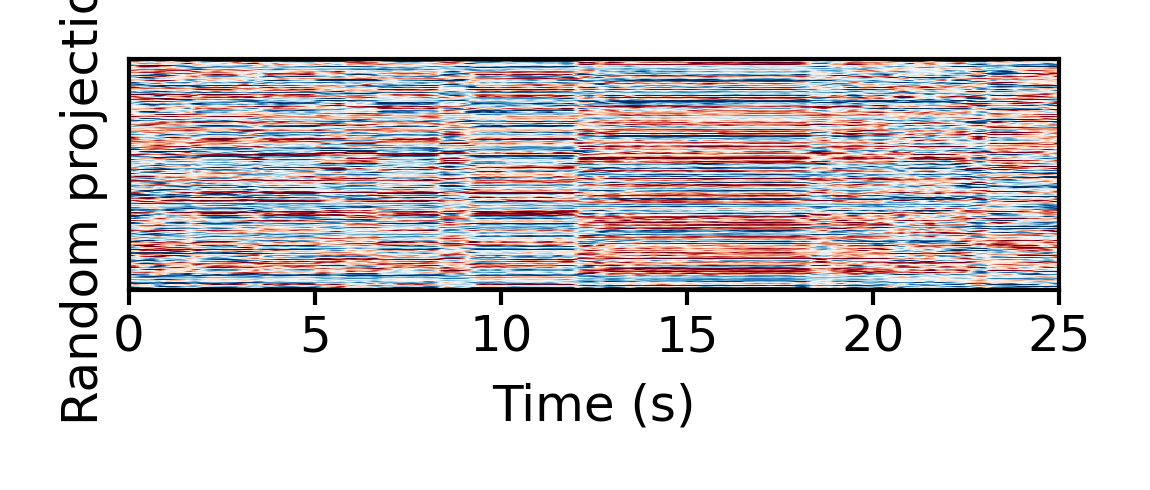

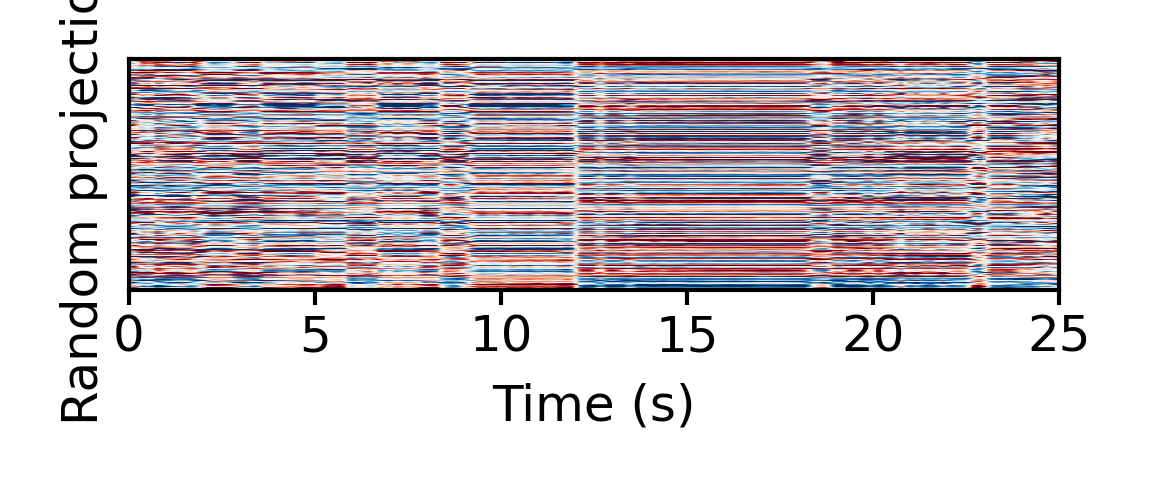

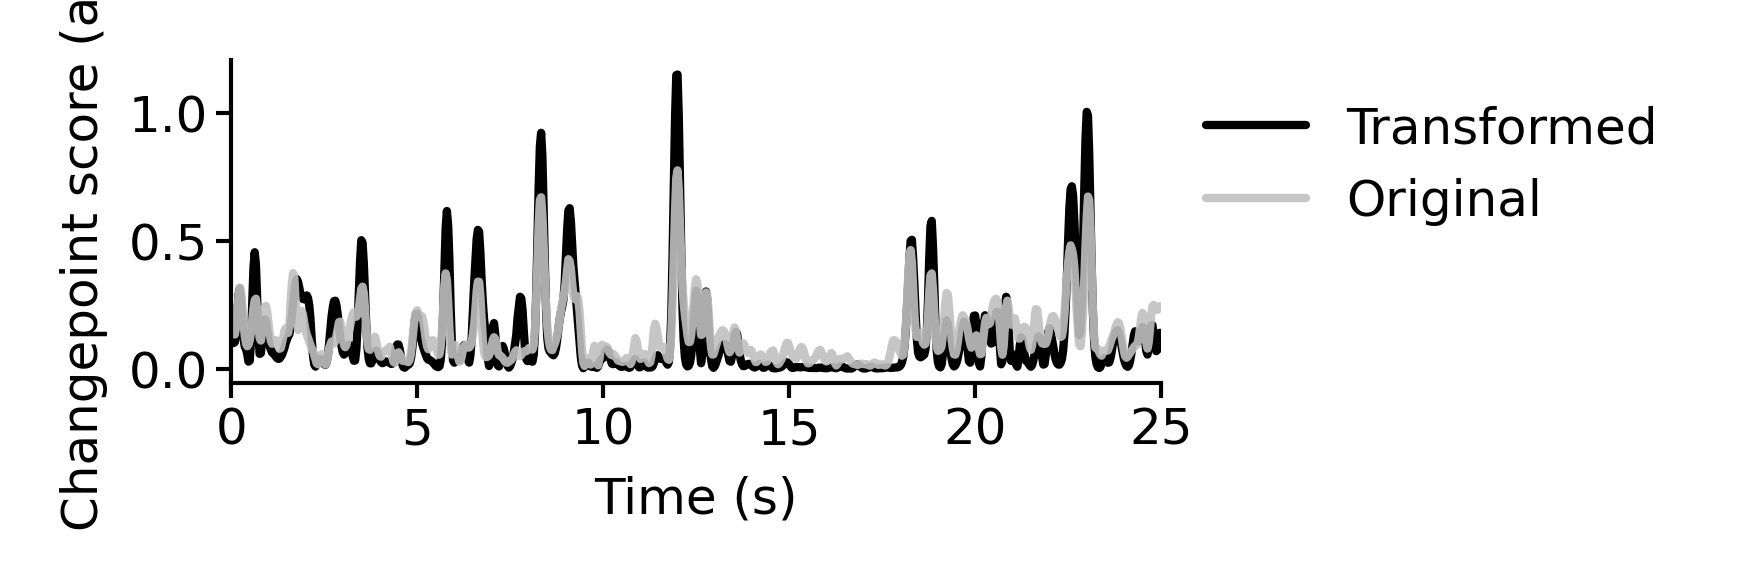

In [11]:
age = 84
session_idx = 1
frames = group_og[age][session_idx]
transformed_frames = group_recon[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=2500, cmap=cmap, lims=lims
)

saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

## Example for 4 weeks

In [12]:
cmap = "RdBu_r"
lims = 1.5

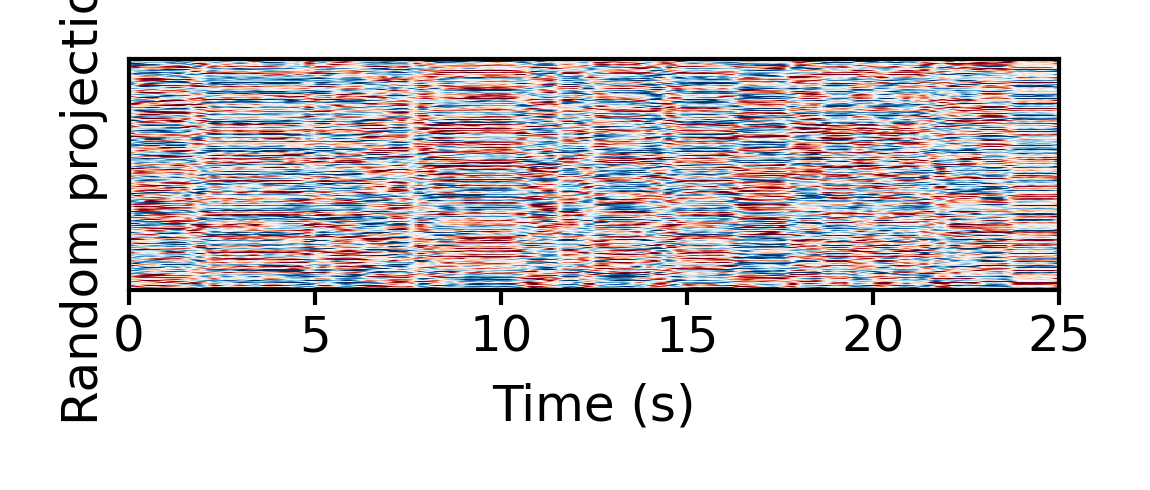

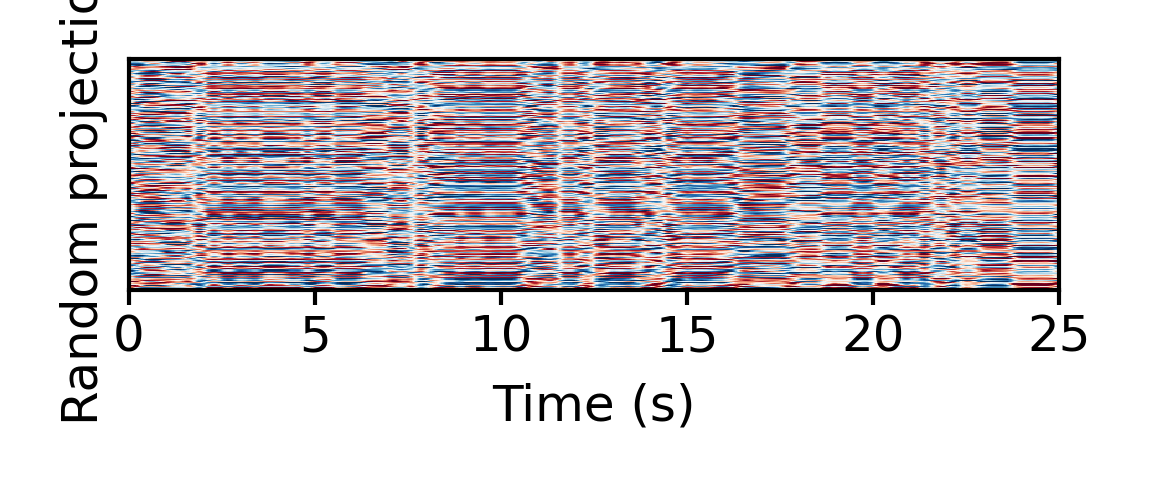

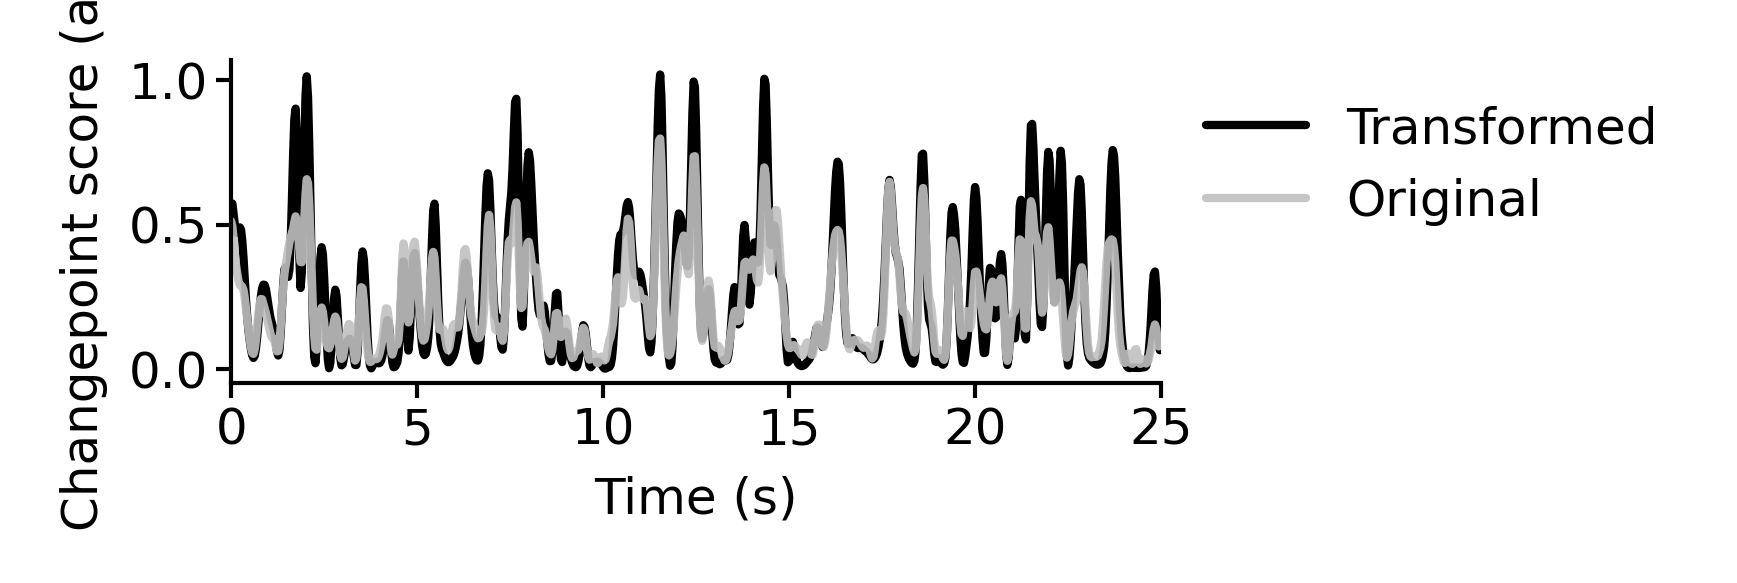

In [13]:
age = 4
session_idx = 1
frames = group_og[age][session_idx]
transformed_frames = group_recon[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=1_200, cmap=cmap, lims=lims
)

saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

## Compute correlation between changepoint scores for all ages

In [14]:
cp_dict = defaultdict(list)
for k, v in tqdm(group_og.items()):
    for frames, recon_frames in zip(v, group_recon[k]):
        cp, _, mdl = compute_changepoints(frames)
        cp_t, _, _ = compute_changepoints(recon_frames, mdl=mdl)

        c = cp.corr(cp_t)
        cp_dict[k].append(c)
        print("age:", k, "corr:", c)

  0%|          | 0/23 [00:00<?, ?it/s]

age: 12 corr: 0.933455440845883
age: 12 corr: 0.9149844108706486
age: 12 corr: 0.9247230774689065
age: 12 corr: 0.9267003893110709
age: 12 corr: 0.9272434850704488
age: 12 corr: 0.9130608736285607
age: 12 corr: 0.9226060244779217
age: 12 corr: 0.9304740211428121
age: 12 corr: 0.9337370775753255
age: 12 corr: 0.8709316822662346
age: 12 corr: 0.9104533266005833
age: 90 corr: 0.8857070917317648
age: 90 corr: 0.869294874998245
age: 90 corr: 0.8643803024297517
age: 90 corr: 0.9091619669035386
age: 90 corr: 0.8946649067965027
age: 90 corr: 0.8825457457347797
age: 90 corr: 0.8886075022543171
age: 90 corr: 0.8941877786944799
age: 90 corr: 0.8463622688186442
age: 90 corr: 0.8915184804084553
age: 90 corr: 0.895463903273305
age: 40 corr: 0.8569833347514523
age: 40 corr: 0.9145076332913568
age: 40 corr: 0.885846207819145
age: 40 corr: 0.8845468027696107
age: 40 corr: 0.9057717843282705
age: 40 corr: 0.8710528128812783
age: 40 corr: 0.909898112467734
age: 40 corr: 0.9197388381200154
age: 40 corr: 0

In [15]:
cp_df = pd.DataFrame(cp_dict)
cp_df = cp_df.melt(var_name="Age", value_name="corr")

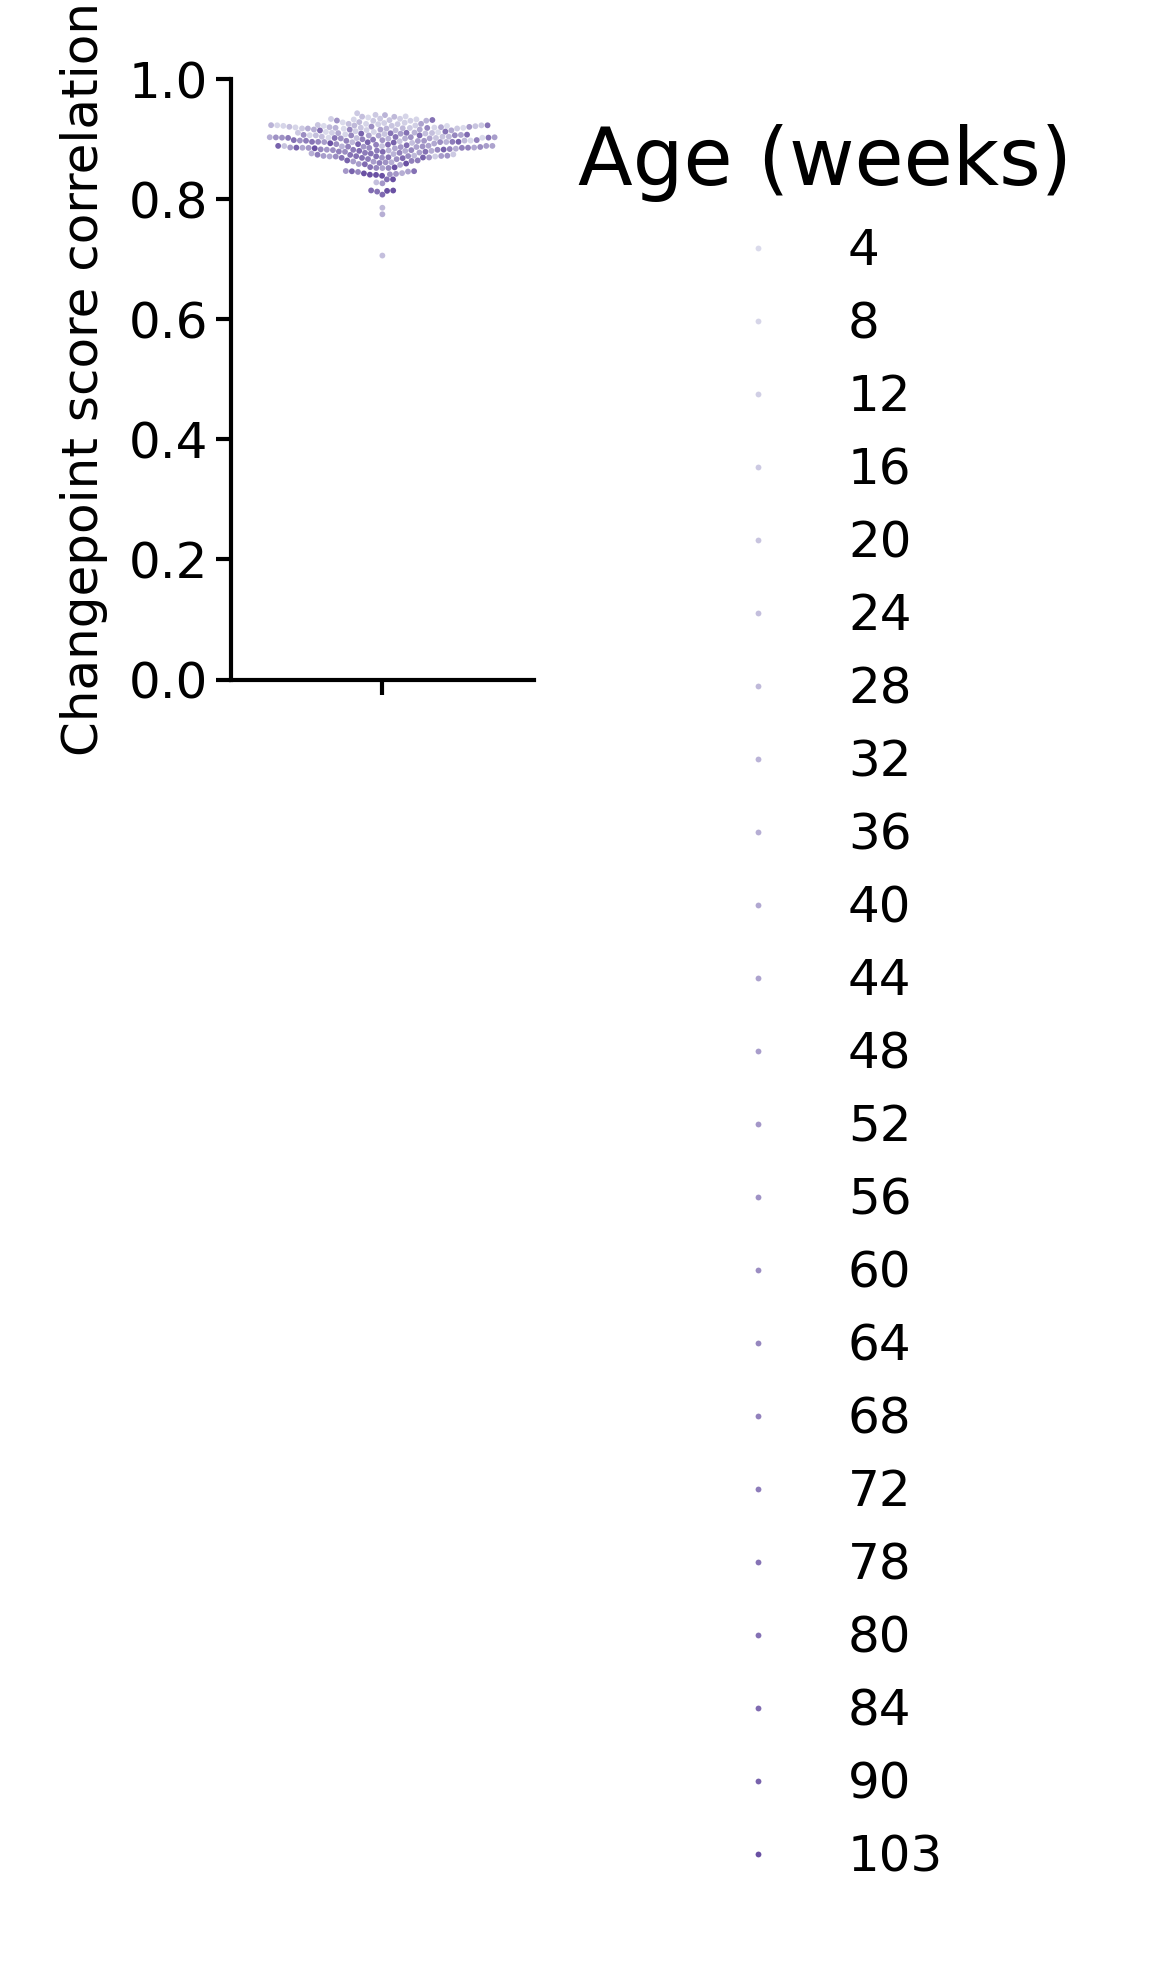

In [16]:
fig = figure(0.65, 1.3)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="Age",
    palette=ONTOGENY_AGE_CMAP,
    size=0.7,
    legend="full",
)
legend(ax, title="Age (weeks)")
ax.set(ylim=(0, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-age-swarmplot");

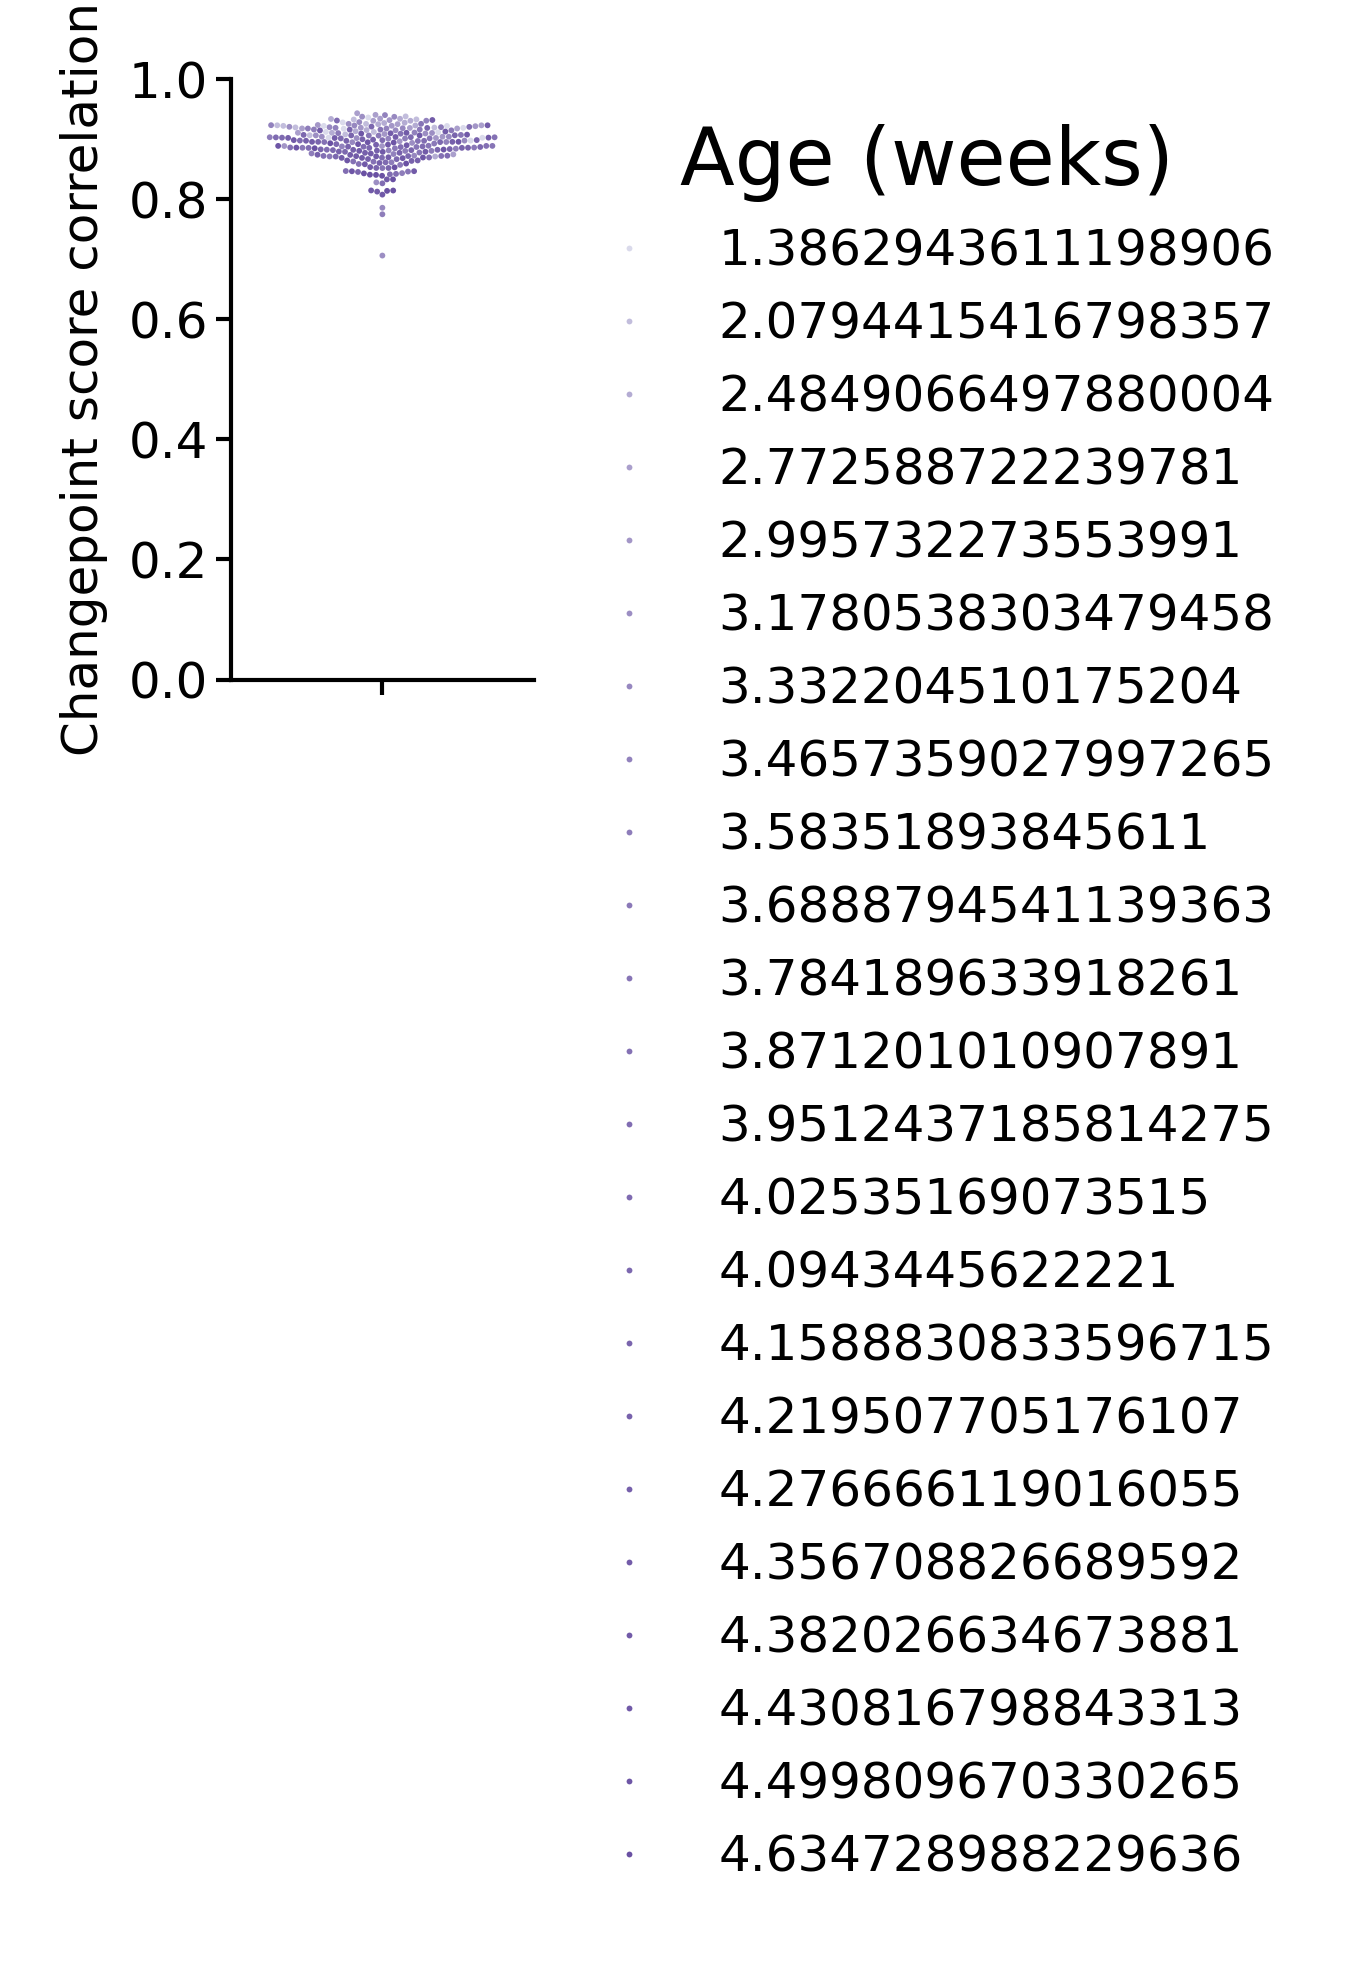

In [17]:
cp_df['log_age'] = np.log(cp_df['Age'])
fig = figure(0.65, 1.3)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="log_age",
    palette=ONTOGENY_AGE_CMAP,
    size=0.7,
    legend="full",
)
legend(ax, title="Age (weeks)")
ax.set(ylim=(0, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-log_age-swarmplot");